## Problem Statement

Identify the label of an image (image of digit) based on the trainign samples

## Dataset Description

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

In [1]:
# Importing required libraries

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
from sortedcontainers import SortedList
import random
from timeit import default_timer as timer
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# read the dataset

data = pd.read_csv('../data/train.csv')

In [3]:
# dimension of the dataset

data.shape

(42000, 785)

In [4]:
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Visualisation

We are plotting several images and graphs below to understand the data better.

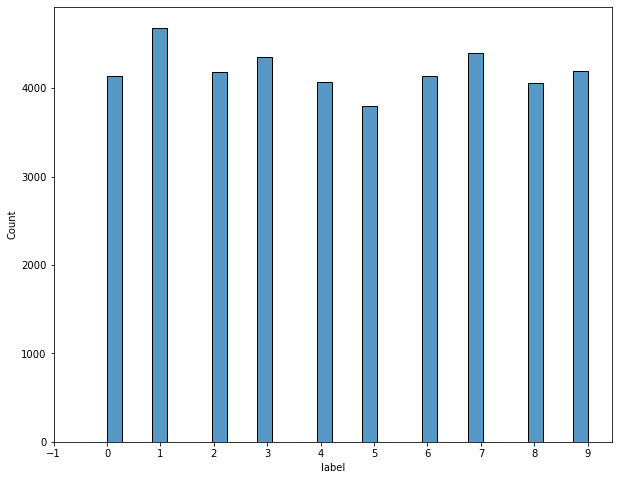

In [5]:
# Plotting the count of each label present in our dataset

sns.histplot(x=data.label)
plt.xticks(np.arange(-1 + min(data.label), 1 + max(data.label),1.0))
plt.show()

##### Based on the plot above we can say that their is nearly an unifrom distribution of images for all the labels

/Users/adityasingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adityasingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adityasingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

<AxesSubplot:xlabel='pixel457', ylabel='Density'>

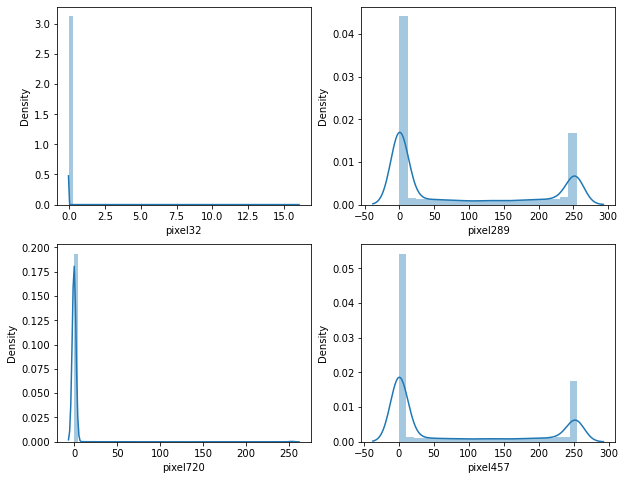

In [6]:
# Density plot of some randomly selected pixels

fig, axes = plt.subplots(2, 2)
sns.distplot(data['pixel32'], ax=axes[0,0])
sns.distplot(data['pixel289'], ax=axes[0,1])
sns.distplot(data['pixel720'], ax=axes[1,0])
sns.distplot(data['pixel457'], ax=axes[1,1])

##### Density plot of some random few pixels shows that edge pixels dont carry much of a value and we can remove them if required

Time taken to complete the visualisation part: 1.9317780669999998


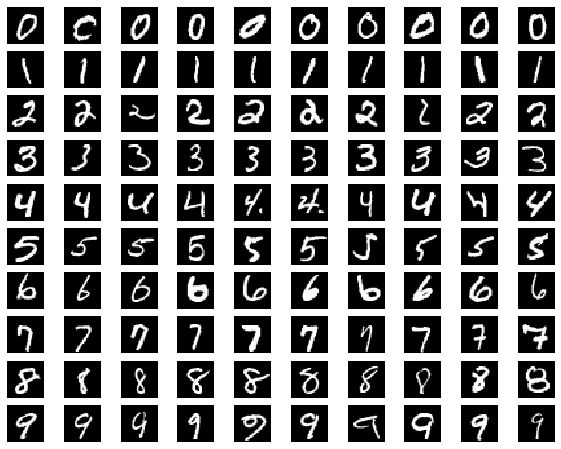

In [7]:
# randomly choosing few rows for each class and then plotting it as an image in matplotlib

startSampleDataForVisualisation = timer()
classes = ['0','1','2','3','4','5','6','7','8','9']
sampledDataForVisualization = pd.DataFrame()
for i in classes:
    samples = data.label[data.label.eq(int(i))].sample(10).index
    sampledDataForVisualization = pd.concat([sampledDataForVisualization, data.iloc[samples]])
    
for i in range(len(sampledDataForVisualization)):
    image = np.array(sampledDataForVisualization.iloc[i][1:]).reshape((28,28))
    plt.subplot(len(classes), 10, i+1)
    plt.imshow(image)
    plt.axis('off')
    
endSampleDataForVisualisation = timer()

print("Time taken to complete the visualisation part: " + str(endSampleDataForVisualisation-startSampleDataForVisualisation))

## KNN implementation

In [8]:
# Function to return training and testing data using the parameter passed by user from randomly shuffled dataset
# to ensure uniform distribution of each kind of class

# Normalising pixel value to 0-255

def train_test_split(data, train_data_number, test_data_number):
    data2numpy = data.to_numpy()
    np.random.shuffle(data2numpy)
    X = data2numpy[:, 1:] / 255.0
    Y = data2numpy[:, 0]
    
    Xtrain, Ytrain = X[:train_data_number], Y[:train_data_number]
    Xtest, Ytest = X[train_data_number:train_data_number+test_data_number], Y[train_data_number:train_data_number+test_data_number]
    return Xtrain, Ytrain, Xtest, Ytest
    

In [15]:
# Calling test_train_split to get required number of datapoints 
# We are taking only 3000 samples for training set and 2000 samples for test set which is computationally efficient.
# Since the original dataset is unifromly distrubuted we can be sure to get a unifrom distribution in this subsample.

X_train, y_train, X_test, y_test = train_test_split(data, 5000, 1000)

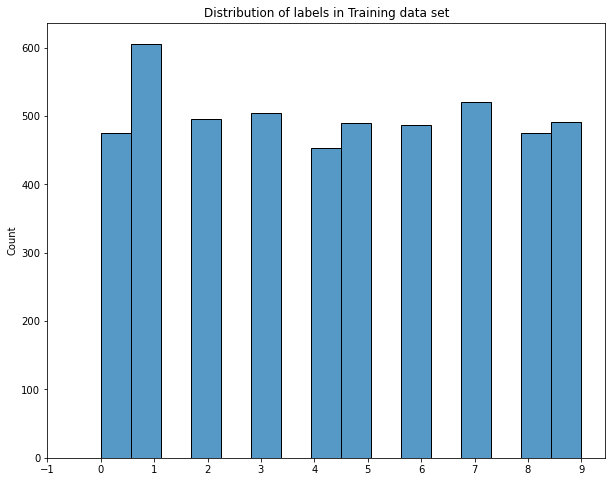

In [16]:
# Plotting the count of each label present in our dataset

sns.histplot(x=y_train)
plt.xticks(np.arange(-1 + min(y_train), 1 + max(y_train),1.0))
plt.title('Distribution of labels in Training data set')
plt.show()

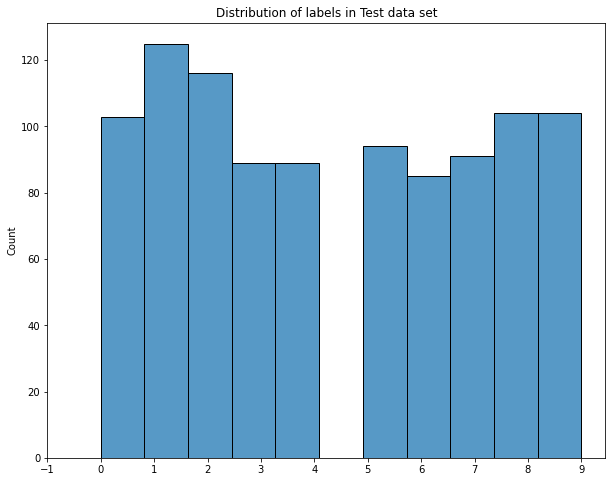

In [17]:
# Plotting the count of each label present in our dataset

sns.histplot(x=y_test)
plt.xticks(np.arange(-1 + min(y_test), 1 + max(y_test),1.0))
plt.title('Distribution of labels in Test data set')
plt.show()

In [18]:
# KNN algorithm implementation
# Distance is measured using dot product of image matrix and then stored in min heap which gives log(n) complexity
# to extract the min and remove the max

# Using the max occurrence of class to predict the class of the current test sample point
# Function returns the prediction array equal to the size of the passed test datapoint array

def knn_predict(X_train, y_train, X_test, k):
    prediction = np.zeros(len(X_test))
    for i, x in enumerate(X_test):
        priorityList = SortedList()
        for j, xt in enumerate(X_train):
            diffImage = x - xt
            d = diffImage.dot(diffImage)
            if len(priorityList) < k:
                priorityList.add((d, y_train[j]))
            else:
                if d < priorityList[-1][0]:
                    del priorityList[-1]
                    priorityList.add((d, y_train[j]))
        votes = {}
        for _, v in priorityList:
            votes[v] = votes.get(v, 0) + 1
        max_votes = 0
        max_votes_class = -1
        for v, count in votes.items():
            if count > max_votes:
                max_votes = count
                max_votes_class = v
        prediction[i] = max_votes_class
    return prediction

In [19]:
# Returns the accuracy of the result taking the predicted class list and actualClass list

def getAccuracy(predictedClass, actualClass):
    return (np.sum(predictedClass == actualClass)/len(predictedClass))

## Algorithm explained

1. A generic KNN algorithm used O(n^2) time to find the k nearest point. If K is large, the complexity can go to O(n^3).
2. There are few basic optimization techniques we have used which are explained below.
3. We have used Priority queue to store the distances which gives the log(n) complexity to fetch the distances as compared to O(n) earlier.
4. We are storing data as numpy array and can use NumPy library.
5. To calculate euclidean distance, we are using dot product and not taking square root as they still give same result.

In [20]:
# Stores the value of K and the associated accuracy for different values of K

valueOfK = []
accuracyForK = []
accuracyForKForChosenDigits = []
predictedValuesForOptimumK = []
maxAccuracy = 0.0
choosenDigitToCalculateAccuracy = int(random.choice(classes))
timeTakenForKNNforGivenK = []
print("Choose digit for accuracy is: " + str(choosenDigitToCalculateAccuracy))
for i in range(1,25):
    startKnn = timer()
    print("Starting for K = " + str(i))
    valueOfK.append(i)
    y_predict = knn_predict(X_train, y_train, X_test, i)
    accuracy = getAccuracy(y_predict, y_test)
    
    # This will be used to plot the confusion matrix for the most optimum value of K
    if accuracy > maxAccuracy:
        maxAccuracy = accuracy
        predictedValuesForOptimumK = y_predict
        
    totalChosenDigitsPresent = np.sum(y_test==choosenDigitToCalculateAccuracy)
    digit_mask = y_test == choosenDigitToCalculateAccuracy
    totalCorrectlyPredicted = np.sum(y_predict[digit_mask] == choosenDigitToCalculateAccuracy)
    chosenDigitSpecificAccuracy = (totalCorrectlyPredicted/totalChosenDigitsPresent)*100.0
    accuracyForK.append(accuracy*100.0)
    accuracyForKForChosenDigits.append(chosenDigitSpecificAccuracy)
    endKnn = timer()
    timeTakenForKNNforGivenK.append(endKnn-startKnn)
    print("Time taken to complete the KNN using K = " + str(i) + " is: " + str(endKnn-startKnn))
    print("Overall accuracy is: " + str(accuracy) + " with choosen digit specific accuracy is: " + str(chosenDigitSpecificAccuracy))
    

Choose digit for accuracy is: 3
Starting for K = 1
Time taken to complete the KNN using K = 1 is: 154.24721460499995
Overall accuracy is: 0.917 with choosen digit specific accuracy is: 91.01123595505618
Starting for K = 2
Time taken to complete the KNN using K = 2 is: 154.1275008519999
Overall accuracy is: 0.917 with choosen digit specific accuracy is: 91.01123595505618
Starting for K = 3
Time taken to complete the KNN using K = 3 is: 155.0356507900001
Overall accuracy is: 0.921 with choosen digit specific accuracy is: 91.01123595505618
Starting for K = 4
Time taken to complete the KNN using K = 4 is: 154.97026489799987
Overall accuracy is: 0.926 with choosen digit specific accuracy is: 92.13483146067416
Starting for K = 5
Time taken to complete the KNN using K = 5 is: 154.35207867000008
Overall accuracy is: 0.924 with choosen digit specific accuracy is: 91.01123595505618
Starting for K = 6
Time taken to complete the KNN using K = 6 is: 154.83638928200003
Overall accuracy is: 0.92 with

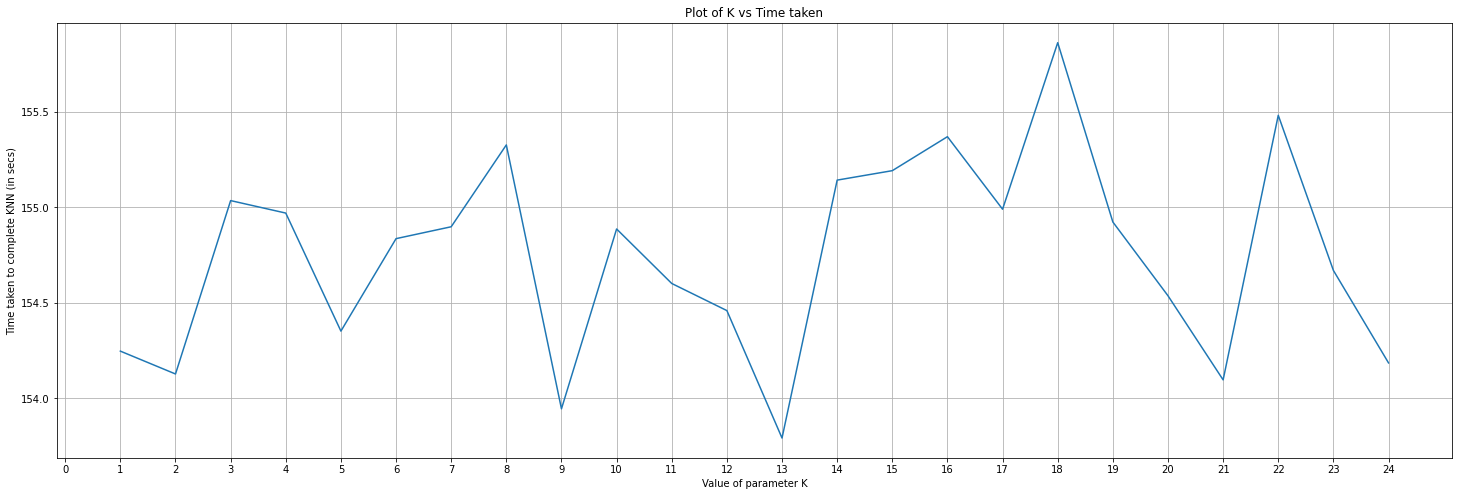

In [21]:
# Plots the curve of K vs the achieved accuracy 
plt.figure(figsize=(25,8))
sns.lineplot(x=valueOfK, y=timeTakenForKNNforGivenK)
plt.xlabel('Value of parameter K')
plt.ylabel('Time taken to complete KNN (in secs)')
plt.title('Plot of K vs Time taken')
plt.xticks(np.arange(min(valueOfK)-1, max(valueOfK)+1, 1.0))
plt.grid()

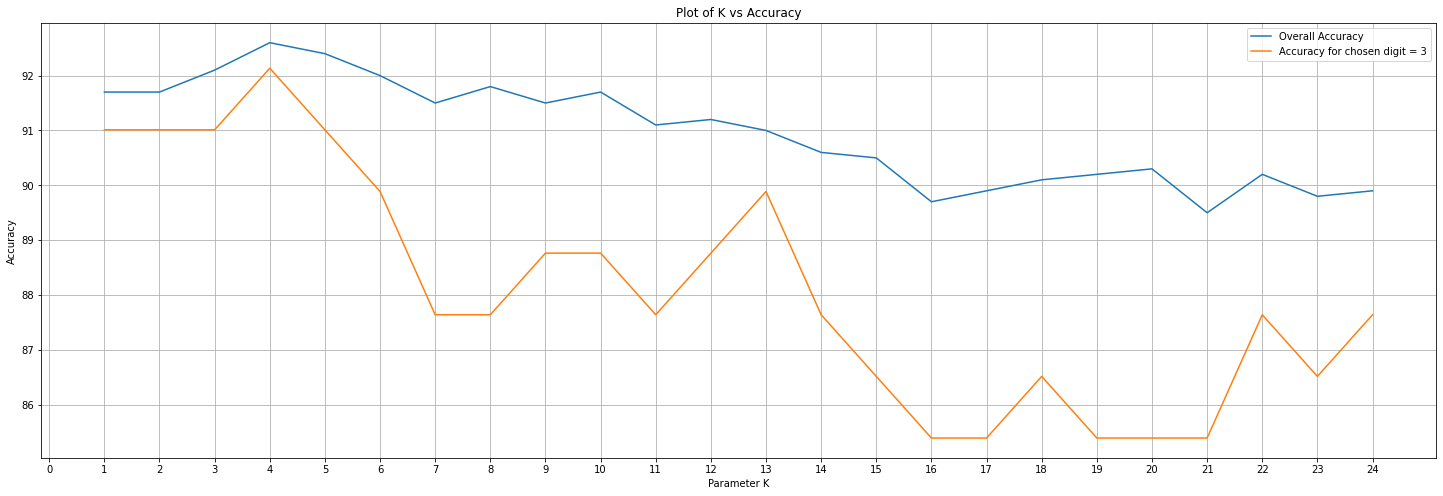

In [22]:
# Plots the curve of K vs the achieved accuracy 
plt.figure(figsize=(25,8))
sns.lineplot(x=valueOfK, y=accuracyForK, label='Overall Accuracy')
sns.lineplot(x=valueOfK, y=accuracyForKForChosenDigits, label='Accuracy for chosen digit = '+str(choosenDigitToCalculateAccuracy))
plt.xlabel('Parameter K')
plt.ylabel('Accuracy')
plt.title('Plot of K vs Accuracy')
plt.xticks(np.arange(min(valueOfK)-1, max(valueOfK)+1, 1.0))
plt.grid()

##### Most optimum value of K and choosen digit accuracy for that optimum K

In [30]:
optimumValueOfK = np.argmax(accuracyForK) + 1
print("Optimum value of K is around: ", optimumValueOfK)
print("Accuracy achieved for chosen digit: " + str(choosenDigitToCalculateAccuracy) + " is: " + str(accuracyForKForChosenDigits[optimumValueOfK]))

Optimum value of K is around:  4
Accuracy achieved for chosen digit: 3 is: 91.01123595505618


### Confusion Matrix

In [24]:
# Generating confusion matrix
rows, cols = (10, 10)
confusionMatrix = [[0 for i in range(cols)] for j in range(rows)]

for i in range(len(y_test)):
    if y_test[i] == predictedValuesForOptimumK[i]:
        confusionMatrix[y_test[i]][y_test[i]]+=1
    else:
        confusionMatrix[y_test[i]][int(predictedValuesForOptimumK[i])]+=1

In [25]:
confusionMatrixDataframe = pd.DataFrame(confusionMatrix)

In [26]:
columnsDict = {}
rowsDict = {}
for i in range(10):
    columnsDict[i] = 'Pedicted value - ' + str(i)
    rowsDict[i] = 'Actual value - ' + str(i)

In [27]:
confusionMatrixDataframe = confusionMatrixDataframe.rename(columns=columnsDict, index=rowsDict)

In [28]:
confusionMatrixDataframe

,Pedicted value - 0,Pedicted value - 1,Pedicted value - 2,Pedicted value - 3,Pedicted value - 4,Pedicted value - 5,Pedicted value - 6,Pedicted value - 7,Pedicted value - 8,Pedicted value - 9
Actual value - 0,102,1,0,0,0,0,0,0,0,0
Actual value - 1,0,122,1,1,1,0,0,0,0,0
Actual value - 2,1,7,103,0,0,0,0,3,1,1
Actual value - 3,1,0,1,82,0,3,0,0,1,1
Actual value - 4,0,1,0,0,81,1,1,0,0,5
Actual value - 5,1,0,0,3,0,88,0,0,0,2
Actual value - 6,0,0,0,0,0,0,84,0,1,0
Actual value - 7,0,1,1,0,0,0,0,83,0,6
Actual value - 8,0,6,0,6,0,4,1,0,85,2
Actual value - 9,0,2,0,0,1,0,0,3,2,96


## Result

1. For 3000 training points and 50 test points, we are getting overall accuracy of 95% for K=4 and digit specific (digit=1) accuracy of 100%.
2. For 5000 training points and 1000 test points we are getting overall accuracy of 92.6% for K=4 as seen from the graph above.
3. The time taken to complete KNN for every value of K is around 155 seconds (2.5 minutes) which means it takes around 0.155 seconds per test point.
4. Accuracy is fairly high as we increase the number of training points.